In [1]:
import torch 
import torch.nn as nn 
from torch.optim import SGD 
import numpy as np 
import matplotlib.pyplot as plt 
import time

In [19]:
%config InlineBackend.figure_format = 'svg'


# Basic Concepts of Machine Learning

Suppose you have an independent dataset $\vec{x}$ and another dataset $\vec{y}$ that is dependent on $\vec{x}$. 

Examples of this are:

+ $x_i$ is the height of a person and $y_i$ is the weight of the person, predicted by the height
+ $x_i$ is a picture of a handwritten digit and $y_i$ is the digit that is written in the picture, so the number itself is predicted by its representation in the picture
+ $x_i$ is a CT scan of a patient and $y_i$ are the pixels corresponding tumors in the scan, so the tumor is predicted certain pixel patterns in the image


The goal of a **neural network** is as follows. Define a function $f$ that depends on parameters $a$ that makes the predictions

$$ \hat{y}_i = f(x_i; a) $$

The predictions $\hat{y}_i$ and the true values $y_i$ shoudl be as close as possible by adjusting the parameters $a$.

The parameters $a$ are adjusted by a **loss function** $L$ that measures the difference between the predictions $\hat{y}_i$ and the true values $y_i$. The loss function is defined as 

$$ L(y, \hat{y}) = \sum_{i=1}^N \left( \hat{y}_i - y_i \right)^2 $$

for an example as trivial as the first one above. 

In general, one has to clearly identify what should be compared in order to determine the similarity between the predictions and the true values, in order to properly design and define the loss function.

In [2]:
x = torch.tensor([[6, 2], [5, 2], [1, 3], [7, 6]]).float()
y = torch.tensor([1, 5, 2, 5]).float()

+ $x_1 = (6, 2), x_2 = (5, 2), \dots$ 
+ $y_1 = 1, y_2 = 5, \dots$

What we need to find is a function $f$ that depends on parameters $a$ that maps the input $\vec{x}$ to the output $\vec{y}$.

In [3]:
x, y

(tensor([[6., 2.],
         [5., 2.],
         [1., 3.],
         [7., 6.]]),
 tensor([1., 5., 2., 5.]))

A core idea of machine learning is to use as many data points as possible to find the best function $f$ that maps the input $\vec{x}$ to the output $\vec{y}$. 

**Idea**: 

1. First multiply each element in $\vec{x}$ by a $8 \times 2$ matrix (16 parameters $a_i$)
2. Then multiply each element in $\vec{x}$ by a $1 \times 8$ matrix (8 parameters $a_i$)

Define a matrix (takes in a 2D vector and outputs a 8D vector)

**IMPORTANT**: When the matrix is created, it is initalized with random values.

In [4]:
M1 = nn.Linear(2, 8, bias=False) # this function takes in a 2D vector and returns an 8D vector (8 is just arbitrary for this example)
M1

Linear(in_features=2, out_features=8, bias=False)

I can pass to $M_1$ the vector $\vec{x}$ (dataset), where each element $x_i$ is an instance of the dataset. 

This dataset is a 2D vector, so I can pass it to $M_1$ and it will output a 8D vector by multiplying each element in $\vec{x}$ by the matrix $M_1$.

In [5]:
M1(x)

tensor([[-5.2691,  5.2286, -0.2458, -4.4349, -3.8910,  2.6982,  1.2514, -3.5692],
        [-4.6219,  4.5361, -0.1088, -3.8837, -3.3692,  2.3647,  0.8158, -3.1923],
        [-2.7265,  2.3027,  0.7279, -2.2423, -1.6622,  1.3800, -1.6074, -2.3385],
        [-8.6887,  8.0681,  0.7704, -7.2409, -5.9333,  4.4270, -1.0370, -6.5615]],
       grad_fn=<MmBackward0>)

I can now generate the new matrix $M_2$ that takes in a 8D vector and outputs a 1D vector.

In [6]:
M2 = nn.Linear(8, 1, bias=False)
M2

Linear(in_features=8, out_features=1, bias=False)

Finally, I can chain the multiplication of the two matrices $M_1$ and $M_2$ to get the final output, as said in the beginning.

In [9]:
M2(M1(x)).squeeze()

tensor([-0.2293, -0.2910, -0.8376, -1.3667], grad_fn=<SqueezeBackward0>)

The predictions we found are not very close to the true values, so we need to adjust the parameters $a$ in order to minimize the loss function $L$. 

The two matrices $M_1$ and $M_2$ constitute the parameters $a$.

What we need to do is to do is to **train** the *neural network*. 

Let's define our custom network $f$:

In [10]:
class my_neural_network(nn.Module):
    def __init__(self):
        super().__init__()
        self.Matrix1 = nn.Linear(2, 8, bias=False)
        self.Matrix2 = nn.Linear(8, 1, bias=False)
    def forward(self, x):
        x = self.Matrix1(x)
        x = self.Matrix2(x)
        return x.squeeze()

Using a class is a good way to define a custom network, as you can conveniently store the parameters $a$ in the class, while inheriting from the `nn.Module` class.

In [11]:
f = my_neural_network()

In [12]:
for par in f.parameters():
    print(par)

Parameter containing:
tensor([[-0.2428, -0.6906],
        [-0.5769,  0.0889],
        [-0.0593, -0.6112],
        [ 0.6794,  0.2053],
        [-0.0832, -0.6082],
        [-0.2675,  0.0695],
        [-0.6002,  0.1153],
        [ 0.1161,  0.6740]], requires_grad=True)
Parameter containing:
tensor([[-0.0075,  0.2225, -0.0799,  0.2529,  0.1428, -0.3092,  0.1780, -0.1969]],
       requires_grad=True)


You can see that these are the same matrices $M_1$ and $M_2$ that we defined before and that we can access using the `parameters()` method.

Let's pass the dataset $\vec{x}$ to the network $f$ and see what happens:

In [13]:
yhat = f(x)
yhat, y

(tensor([-0.2426, -0.2337, -0.2932, -0.6305], grad_fn=<SqueezeBackward0>),
 tensor([1., 5., 2., 5.]))

Everything is working correctly, so we can now define the loss function $L$ and the optimizer.

# Adjusting $a$ so that $\vec{\hat{y}}$ and $\vec{y}$ are as close as possible

We can define the loss function $L$ as the mean squared error between the predictions $\vec{\hat{y}}$ and the true values $\vec{y}$. The function is conveniently defined in the `torch.nn` module.

In [14]:
L = nn.MSELoss()
L(y, yhat)

tensor(16.4743, grad_fn=<MseLossBackward0>)

Let's check if it is actually doing what we want, i.e. let's compute the regular mean squared error between the predictions $\vec{\hat{y}}$ and the true values $\vec{y}$.

In [15]:
torch.mean((y - yhat)**2)

tensor(16.4743, grad_fn=<MeanBackward0>)

Note that $L$ is a function of the parameters $a$, $L = L(a)$ (remember that it depends on $\hat{y}$ which depends on $a$). 

The **key idea behind machine learning** is to compute 

$$ \displaystyle\frac{\partial L}{\partial a_i} $$

for each parameter $a_i$ of the newtork $f$. Then we can adjust each parameter $a_i$ as follows

$$ \displaystyle a_i \rightarrow a_i - \eta \frac{\partial L}{\partial a_i} $$

where $\eta$ is the **learning rate**.

The idea is to do this over and over again, until the loss function $L$ is minimized. This is called **gradient descent**.

+ Each pass of the full data set $\vec{x}$ is called an **epoch**. 

The `SGD` optimizer (stochastic gradient descent) takes in all model parameters along with the learning rate $\eta$ and performs the update of the parameters $a_i$ as described above.

In [16]:
opt = SGD(f.parameters(), lr=0.001)

Now we can let it adjust the parameters for say 50 epochs and see what happens.

In [17]:
losses = []

for _ in range(50):
    opt.zero_grad() # reset previous epoch's gradient, otherwise it would be computed cumulatively
    loss_value = L(f(x), y) # compute loss
    loss_value.backward() # compute the gradient 
    opt.step() # perform iteration using the gradient above 
    losses.append(loss_value.item())

Plot the loss function $L(a)$ as a function of the number of epochs 

Text(0.5, 0, 'Number of Epochs')

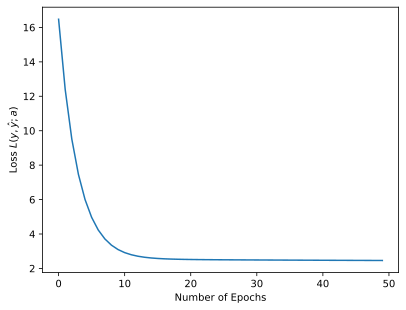

In [20]:
plt.plot(losses)
plt.ylabel('Loss $L(y, \hat{y}; a)$')
plt.xlabel('Number of Epochs')

Let's see the results of the training, after 50 epochs. The plot already shows that with this specific model we've built, our network's optimization will stall asintotically after about 10 epochs. The implication is that this is as low as the loss function can go and that our predictions can't possibly improve any further with this model.

In [27]:
print('predictions\n', f(x))
print('actual values\n', y)

predictions
 tensor([3.1088, 2.7206, 1.5574, 5.0559], grad_fn=<SqueezeBackward0>)
actual values
 tensor([1., 5., 2., 5.])
